# BARNN built from scratch

# [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/dario-coscia/barnn/blob/main/notebooks/example.ipynb)

In this tutorial, we will walk through building a Bayesian Autoregressive Recurrent Neural Network (BARNN) from scratch and applying it to a simple time-series dataset. The BARNN model is designed to perform Uncertainty Quantification (UQ) in time-series forecasting. To achieve this, we'll implement two key features of the BARNN framework:

1. *Variational Dropout Approximation*: This technique approximates the uncertainty of the model's parameters by applying dropout during training and inference, treating the network as a Bayesian neural network.
2. *Aggregated Variational Posterior in Time Prior*: This ensures the autoregressive model' is efficient and well-calibrated.

In [1]:
# importing the modules
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader

## Building a simple time series dataset

We will work with a dataset based on a sine wave with added random noise. The goal is to reproduce this noisy sine wave (time-series of $100$ observation). Below, we plot some sample trajectories. The model is trained autoregressively: it takes the last 5 sequence states as input and predicts the next 5.

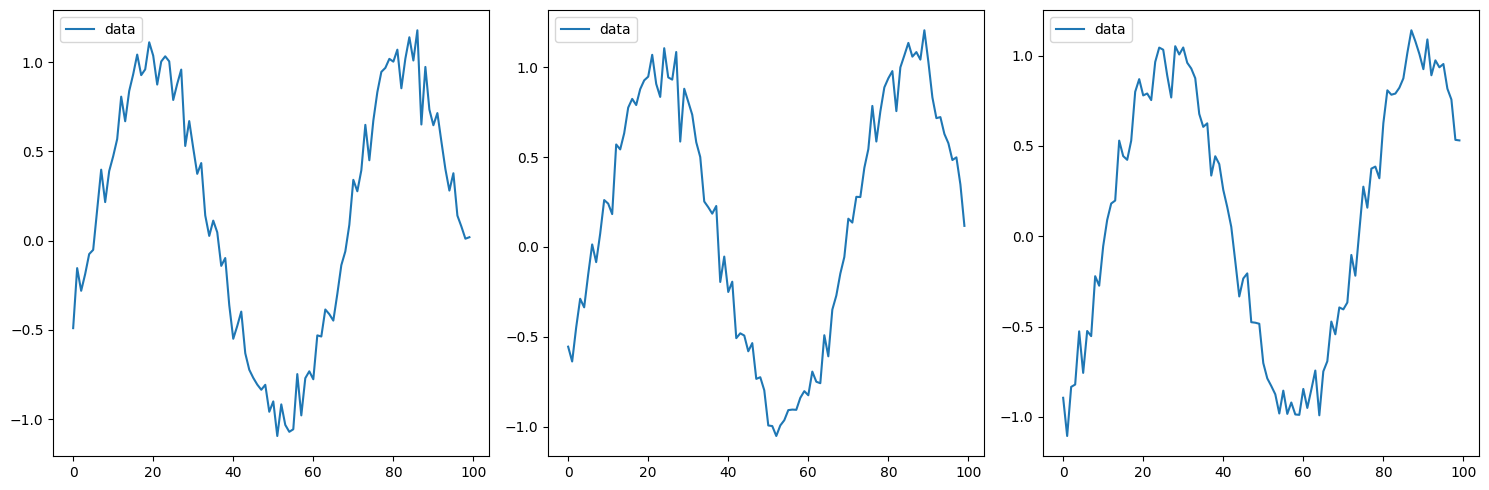

In [2]:
# Predict the trajectory
@torch.no_grad
def autoregressive_inference(model, input, num_steps):
    model.eval()
    predictions = [input]
    with torch.no_grad():
        for _ in range(num_steps-1):
            output = model(predictions[-1])
            predictions.append(output)
    return torch.cat(predictions, dim=-1)

# Generate synthetic sine wave data (noisy)
def generate_sine_wave(T=100, noise_level=0.1):
    shift = torch.rand(1)*torch.pi*0.5
    time = torch.arange(0, T, dtype=torch.float32)
    data = torch.sin(0.1 * time  - shift) + noise_level * torch.randn(T)  # Add some noise
    return data

# Prepare the data using a sliding window approach
def create_sliding_windows(data, window_size):
    # Generate a single random index for each time series in the batch
    random_t = torch.randint(low=window_size, high=data.shape[1] - window_size, size=(data.shape[0],)).int()
    
    # Create inputs and targets using the random indices for each time series
    inputs = torch.stack([data[i, random_t[i] - window_size:random_t[i]] for i in range(data.shape[0])])
    targets = torch.stack([data[i, random_t[i]:random_t[i] + window_size] for i in range(data.shape[0])])
    
    return inputs, targets

# Plot some data
def plot_data(data, solution=None, confidence=None):
    indexes = torch.randint(0, data.shape[0], (3,))
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns
    for idx, ax in zip(indexes, axes):
        ax.plot(data[idx], label='data')
        # If a solution is provided, plot it in the second subplot
        if solution is not None:
            ax.plot(solution[idx], label='prediction', color='orange')
        # If confidence intervals are provided, plot them in the third subplot
        if confidence is not None:
            ax.fill_between(range(len(data[idx])), solution[idx]-3*confidence[idx], solution[idx]+3*confidence[idx], alpha=0.2, label='confidence')
        ax.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

# Generate time series dataset (2048 training, 128 testing)
time_series = torch.stack([generate_sine_wave() for _ in range(2048)], dim=0)
time_series_test = torch.stack([generate_sine_wave() for _ in range(128)], dim=0)
inputs, targets = create_sliding_windows(time_series, 5)

# Build dataloader
dataloader = DataLoader(
    TensorDataset(inputs, targets),
    128
)
criterion = torch.nn.MSELoss()
max_epochs = 1000

# plot trajectories
plot_data(time_series)


Now we train a simple autoregressive network just to see the performance and the need to quantify the uncertainty.

In [3]:
class SimpleNN(nn.Module):
    def __init__(self, window_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(window_size, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, window_size)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

# Here we train
criterion = nn.MSELoss()
model = SimpleNN(window_size=5)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
max_epochs = 1000

for epoch in range(max_epochs):
    for inputs, targets in dataloader:
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{max_epochs}], Loss: {loss.item():.4f}')

Epoch [100/1000], Loss: 0.0146
Epoch [200/1000], Loss: 0.0135
Epoch [300/1000], Loss: 0.0133
Epoch [400/1000], Loss: 0.0129
Epoch [500/1000], Loss: 0.0125
Epoch [600/1000], Loss: 0.0132
Epoch [700/1000], Loss: 0.0127
Epoch [800/1000], Loss: 0.0125
Epoch [900/1000], Loss: 0.0122
Epoch [1000/1000], Loss: 0.0117


Onced trained we can autoregressively predict the future states by unrolling the initial state multiple times

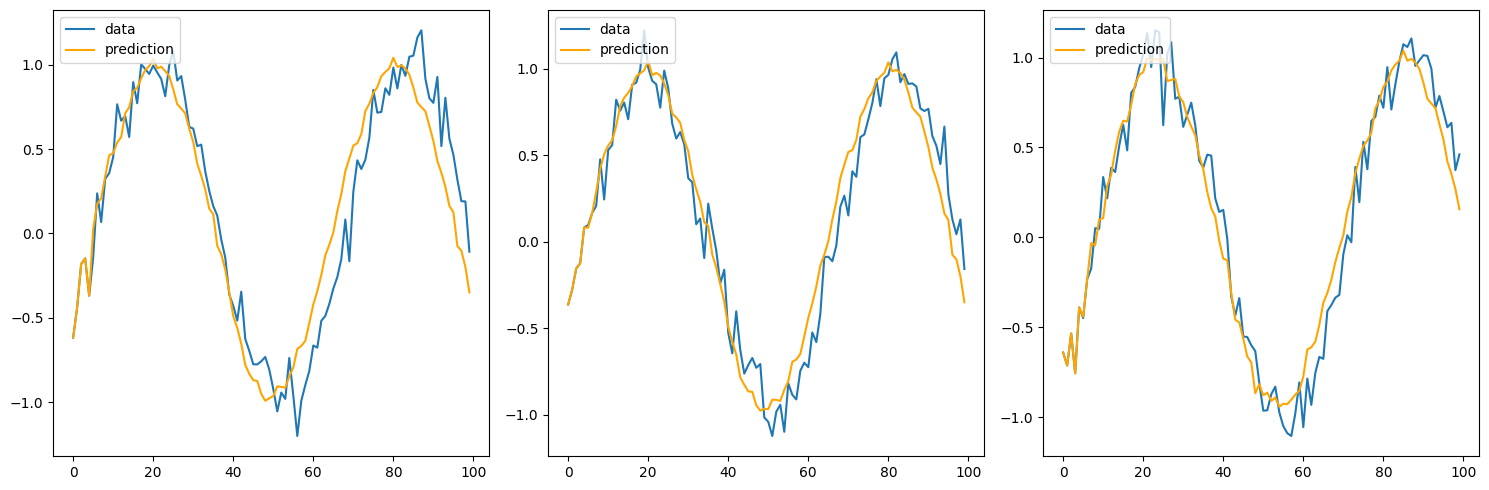

In [4]:
# unrolling to compute the solution
sol = autoregressive_inference(model, time_series_test[:, :5], time_series_test.shape[1]//5)
plot_data(time_series_test, sol)

As you can see, the model captures the general trend, but it occasionally makes inaccurate predictions. Uncertainty quantification models can help address this issue by providing confidence intervals around the predictions. For this reason we present BARNN.

## Linear BARNN layer using the local reparametrization trick

BARNN re-interpret VD for sampling dynamic weights $\bm{\omega}_t$ during training and inference. Our goal is to do a reparametrization of the weights $\bm{\omega}_t = f(\bm{\Omega}, \bm{\alpha}_t, \bm{\epsilon})$, with $\bm{\Omega}$ static-deterministic network weights, $\bm{\alpha}_t$ deterministic time-dependent variational weights, $\bm{\epsilon} \sim p(\bm{\epsilon})$ some random noise, and $f$ a differentiable function. This parametrization is very flexible: (i) it allows to apply the global-reparametrization trick; (ii) it uses fixed network weights $\bm{\Omega}$ enabling to scale the Bayesian methodology to large networks; (iii) it incorporates time and previous state dependency by perturbing $\bm{\Omega}$ with deterministic time-dependent variational weights $\bm{\alpha}_t$, and adds stochasticity with random noise $\bm{\epsilon}$, making the methodology easily implementable with little change to the main autoregressive or recurrent model.

We now implement the Linear BARNN layer (convolutional extensions 1D/2D are provided in `barnn.pde.layers`). Notice the layer takes an additional argument (`alpha`) this represents the $\bm{\alpha}_t$ deterministic time-dependent variational weights provided by the posterior. Finally, the `kl` function computes the tVAMP prior hyperparameters and computes the distance between prior and posterior distribution.

In [ ]:
class LinearBARNN(torch.nn.Linear):
    def forward(self, input, alpha):
        # here we do the VD approximation
        mean = alpha * (torch.nn.functional.linear(input, self.weight) + self.bias)
        var = alpha.pow(2) * (torch.nn.functional.linear(input.pow(2), self.weight.pow(2)) + self.bias.pow(2))
        return mean + torch.sqrt(var+1e-18)*torch.randn_like(mean)
    
    def kl(self, alpha):
        # here we implement the tVAMP
        scale = self.weight.shape.numel() + (self.bias.shape.numel() if self.bias is not None else 0)
        mean_alpha = alpha
        var_alpha = alpha.pow(2)
        mean_beta = mean_alpha.mean(0, keepdim=True)
        var_beta = var_alpha.mean(0, keepdim=True)
        kl = scale * 0.5 * ((mean_alpha-mean_beta).pow(2)/var_beta + (var_alpha/var_beta) - 1 - torch.log(var_alpha/var_beta))
        return kl 

Now that we have the `BARNN` layer we are basically done! Substitute the linear layers with the BARNN layers in the main model. BARNN has an additional network for the posterior to return the variational weights $\bm{\alpha}$. Usually this network is way smaller than the main network.

In [6]:
# Simple feedforward neural network
class BARNN(nn.Module):
    def __init__(self, window_size):
        super(BARNN, self).__init__()
        self.fc1 = torch.nn.Linear(window_size, 512) # we never put barnn on the first layer (as usually done with Dropout methods)
        self.fc2 = LinearBARNN(512, 512)
        self.fc3 = LinearBARNN(512, window_size)
        self.posterior = torch.nn.Sequential(
            torch.nn.Linear(window_size, 8),
            torch.nn.ReLU(),
            torch.nn.Linear(8, 8),
            torch.nn.ReLU(),
            torch.nn.Linear(8, 2),
            torch.nn.Sigmoid())

    def forward(self, x):
        # compute dropout rates
        p = self.posterior(x)
        alphas = p / (1 - p)
        # perform forward
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x, alphas[:, 0][:, None]))
        x = self.fc3(x, alphas[:, 1][:, None])
        # compute kls
        self.kl=0
        self.kl = sum(
            [self.fc2.kl(alphas[:, 0][:, None]).mean() + 
            self.fc3.kl(alphas[:, 1][:, None]).mean()])
        return x


criterion = nn.MSELoss()
model = BARNN(window_size=5)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(max_epochs):
    for inputs, targets in dataloader:
        model.train()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets) + model.kl

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{max_epochs}], Loss: {loss.item():.4f}, KL {model.kl:.4f}')

Epoch [100/1000], Loss: 0.0246, KL 0.0010
Epoch [200/1000], Loss: 0.0192, KL 0.0000
Epoch [300/1000], Loss: 0.0179, KL 0.0000
Epoch [400/1000], Loss: 0.0167, KL 0.0000
Epoch [500/1000], Loss: 0.0174, KL 0.0000
Epoch [600/1000], Loss: 0.0175, KL 0.0000
Epoch [700/1000], Loss: 0.0173, KL 0.0000
Epoch [800/1000], Loss: 0.0163, KL 0.0000
Epoch [900/1000], Loss: 0.0172, KL 0.0000
Epoch [1000/1000], Loss: 0.0170, KL 0.0000


We now procede in computing autoregressively the states as previusly done. We use $100$ ensemble members to compute the statistics.

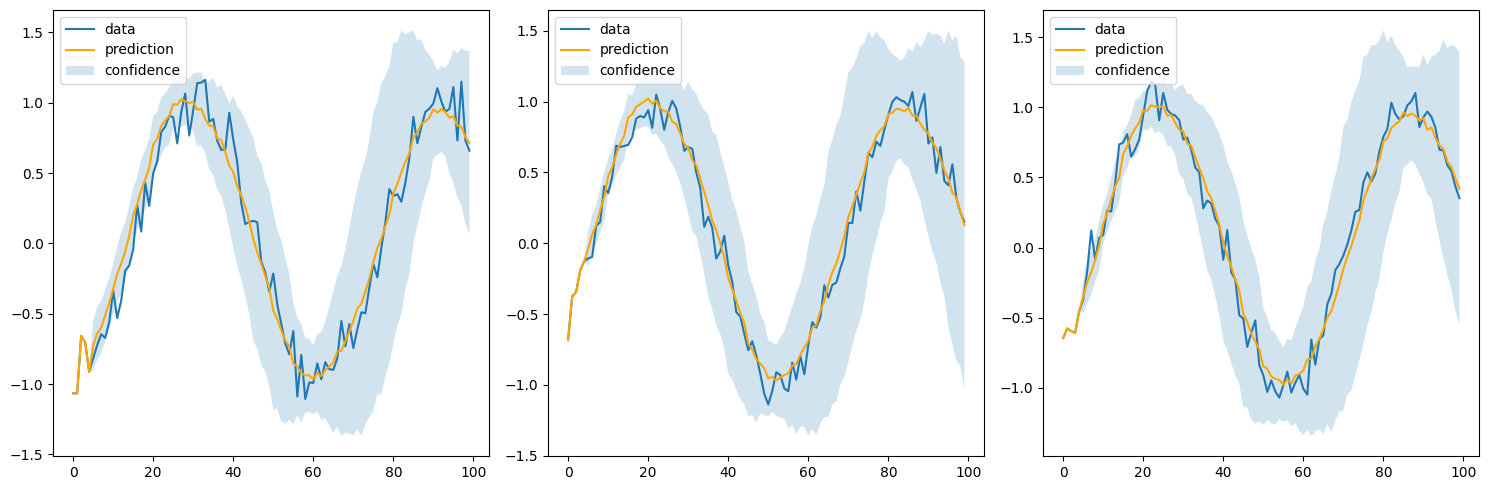

In [7]:
sols = torch.stack([autoregressive_inference(model, time_series_test[:, :5], time_series_test.shape[1]//5) for _ in range(100)], dim=0)
mean, std = sols.mean(0), sols.std(0)
plot_data(time_series_test, mean, std)

As you can see BARNN obtains similar results visually in terms of prediction, but with the addition of confidence bands which are very local! 

## Conclusions and Tips
In this tutorial we have shown how to implement BARNN from scratch. Obviusly this tutorial is not make the most performant model but it is only intended to show the key steps in building BARNN. Finally, we share few tips if you are interested in using BARNN in your work that helped us:

1. We found that BARNN works very well when the parameter dimension of the main network is bigger than the posterior encoder parameter dimension. This is the case of the molecules and pdes experiments.
2. We suggest to never apply BARNN to the first layer of the main network (this is generally the norm with dropout techniques).
3. The local reparametrization trick is very useful to decrease the variance in training, but we found that even perturbing the input (and not the activations) was sufficently most of the times to obtain good uncertainties
4. Using a very large batch size can sometimes be problematic, we think this is due to the prior we are using. Studying effective prior is another interesting research direction.